In [3]:
# Import libraries
import nmrglue as ng # This is for processing the Bruker data
import matplotlib.pyplot as plt # This is for making the plots
import numpy as np # This is for polynomial fitting
from scipy.optimize import curve_fit # This is for Lorentzian fitting
print("Import OK")

Import OK


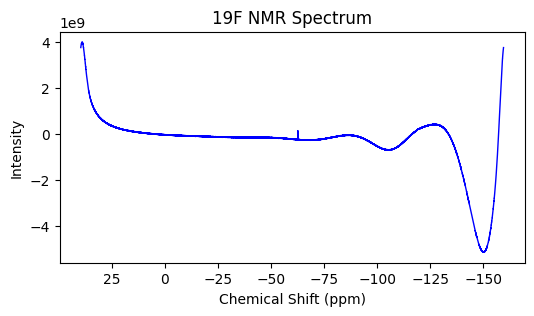

In [4]:
# Read data
dic, data = ng.bruker.read("test_data/single/3")
data = ng.bruker.remove_digital_filter(dic, data)

# data = ng.proc_base.zf_size(data, 32768)    # zero fill to 32768 points
data = ng.proc_base.fft(data)               # Fourier transform
data = ng.proc_base.ps(data, p0=-25.0)      # phase correction
data = ng.proc_base.di(data)                # discard the imaginaries
data = ng.proc_base.rev(data) 

udic = ng.bruker.guess_udic(dic, data)
uc = ng.fileiobase.uc_from_udic(udic)
ppm_scale = uc.ppm_scale()

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ppm_scale, data, color="blue", lw=1)
ax.set_xlabel("Chemical Shift (ppm)")
ax.set_ylabel("Intensity")
ax.set_title("19F NMR Spectrum")
ax.invert_xaxis()  # Standard NMR convention
plt.show()

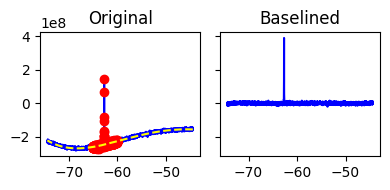

In [5]:
# Baseline
ppm_axis = ppm_scale[14000:19000]
data_axis = data[14000:19000]

# Identify points outside the -60 to -65 ppm range for fitting
mask = (ppm_axis < -60) & (ppm_axis > -65)  # Mask for exclusion

# Baseline selection (only using points outside the exclusion zone)
ppm_baseline = ppm_axis[~mask]
data_baseline = data_axis[~mask]

# Fit a polynomial (degree 3)
degree = 4
coeffs = np.polyfit(ppm_baseline, data_baseline, degree)

# Evaluate baseline fit
baseline_fit = np.polyval(coeffs, ppm_axis)

# Apply baseline correction
corrected_data = data_axis - baseline_fit

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=True)  # Same height, small width

# Left plot: Original data with baseline fit
axes[0].plot(ppm_axis, data_axis, color="blue")
axes[0].plot(ppm_axis[mask], data_axis[mask], 'ro')  # Red points
axes[0].plot(ppm_axis, baseline_fit, '--', color="yellow")
axes[0].set_title("Original")

# Right plot: Baseline-corrected spectrum
axes[1].plot(ppm_axis, corrected_data, color="blue")
axes[1].set_title("Baselined")


plt.tight_layout()  # Adjust spacing for small figure
plt.show()

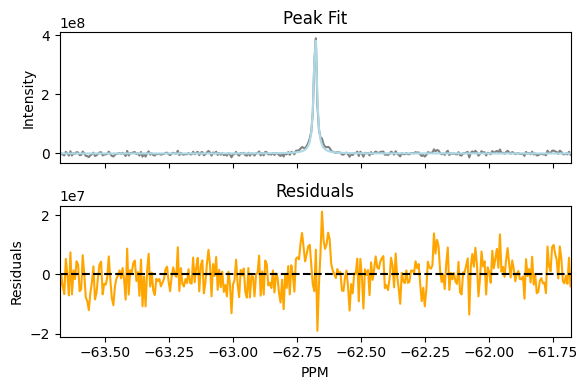

In [18]:
# Define Lorentzian function
def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

# Select a region containing the peak (adjust if necessary)
peak_mask = (ppm_axis > -70) & (ppm_axis < -55)  # Adjust range as needed
ppm_peak = ppm_axis[peak_mask]
data_peak = corrected_data[peak_mask]

# Estimate initial parameters (A, x0, gamma)
A_guess = max(data_peak)  # Peak height
x0_guess = ppm_peak[np.argmax(data_peak)]  # Peak position
gamma_guess = 0.2  # Approximate width, adjust as needed

p0 = [A_guess, x0_guess, gamma_guess]

# Perform curve fitting
popt, _ = curve_fit(lorentzian, ppm_peak, data_peak, p0=p0)

# Extract fitted parameters
A_fit, x0_fit, gamma_fit = popt
lorentzian_fit = lorentzian(ppm_peak, A_fit, x0_fit, gamma_fit)

# Calculate residuals
residuals = data_peak - lorentzian_fit

# Define new x-axis limits
x_min = x0_fit - 1
x_max = x0_fit + 1
zoom_mask = (ppm_axis > x_min) & (ppm_axis < x_max)

# Plot results with residuals below
fig, ax = plt.subplots(figsize=(6, 4), nrows=2, sharex=True)  # Two subplots: one for data, one for residuals

# Plot the main spectrum and fitted curve
ax[0].plot(ppm_axis[zoom_mask], corrected_data[zoom_mask], color="grey")
ax[0].plot(ppm_peak, lorentzian_fit, color="lightblue")  # Fitted peak
ax[0].set_xlim(x_min, x_max)  # Set x-axis limits
ax[0].set_title("Peak Fit")
ax[0].set_ylabel("Intensity")

# Plot residuals
ax[1].plot(ppm_peak, residuals, color="orange", label="Residuals")
ax[1].axhline(0, color="black", linestyle="--")  # Add zero line for reference
ax[1].set_xlabel("PPM")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")

plt.tight_layout()
plt.show()
